**Importing libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS= set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Exploratory Data Analysis**

In [ ]:
data = pd.read_excel("/content/finphrase_data.csv.xlsx")

In [ ]:
data.head()

,rating,verifiedreviews,feedback
0,5.0,"Great job, Wyndham Capital! Each person was pr...",1.0
1,5.0,Matthew Richardson is professional and helpful...,1.0
2,5.0,We had a past experience with Wyndham Mortgage...,1.0
3,5.0,We have been dealing with Brad Thomka from the...,1.0
4,5.0,I can't express how grateful I am for the supp...,1.0


In [ ]:
print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'verifiedreviews' 'feedback']


In [ ]:
data.isnull().sum()

rating               0
verifiedreviews      0
feedback           180
dtype: int64

In [ ]:
data[data['verifiedreviews'].isna() == True]

,rating,verifiedreviews,feedback


In [ ]:
data.dropna(inplace=True)

In [ ]:
print(f"Dataset shape afteer dropping null values : {data.shape}")

Dataset shape afteer dropping null values : (1325, 3)


In [ ]:
data['length'] = data['verifiedreviews'].apply(len)

In [ ]:
data.head()

,rating,verifiedreviews,feedback,length
0,5.0,"Great job, Wyndham Capital! Each person was pr...",1.0,126
1,5.0,Matthew Richardson is professional and helpful...,1.0,159
2,5.0,We had a past experience with Wyndham Mortgage...,1.0,462
3,5.0,We have been dealing with Brad Thomka from the...,1.0,605
4,5.0,I can't express how grateful I am for the supp...,1.0,341


In [ ]:
print(f"'verifiedreviews' column value: {data.iloc[10]['verifiedreviews']}")
print(f"Length of review: {len(data.iloc[10]['verifiedreviews'])}")
print(f"'length' column value : {data.iloc[10]['length']}")

'verifiedreviews' column value: Working with Michelle and Wyndham went really well for me. As a first time homeowner and this being my first refinance, I feel that this process was smooth and successful. I will definitely recommend Michelle to friends and family.
Length of review: 231
'length' column value : 231


In [ ]:
data.dtypes

rating             float64
verifiedreviews     object
feedback           float64
length               int64
dtype: object

In [ ]:
len(data)
print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5.0    845
4.0    227
1.0     93
3.0     64
4.5     41
2.0     27
3.5     18
0.5      7
2.5      2
1.5      1
Name: count, dtype: int64


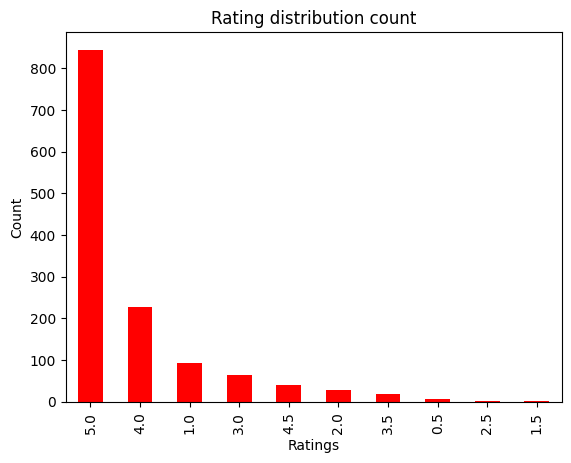

In [ ]:
data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [ ]:
print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5.0    63.77
4.0    17.13
1.0     7.02
3.0     4.83
4.5     3.09
2.0     2.04
3.5     1.36
0.5     0.53
2.5     0.15
1.5     0.08
Name: count, dtype: float64


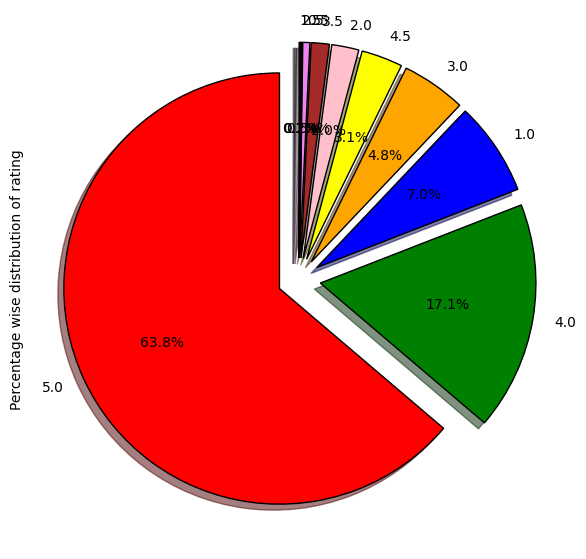

In [ ]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue', 'orange', 'yellow', 'pink', 'brown', 'violet', 'black', 'white')
wp = {'linewidth':1,"edgecolor":'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distribution of rating')
from io import BytesIO
graph = BytesIO()
fig.savefig(graph,format="png")

In [ ]:
print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1.0    1218
0.0     107
Name: count, dtype: int64


In [ ]:
review_0 = data[data['feedback']==0].iloc[1]['verifiedreviews']
print(review_0)

This loan started off quite well. Our rep, Donna, was friendly and quick to respond to questions. She clearly explained how things would unfold, and it all sounded great. What I didn't count on was that the Bank never kept a single promise she made. I had the same problem with this Bank 15 or more times. I would ask for assurance about something, Donna would respond that things would be completed as I wished, and her promise was violated by the Bank EVERY SINGLE TIME. For example, in our first or second conversation, I explained to Donna that my wife would be traveling out of the country 11 weeks after beginning the loan process. Would it be a problem to get the loan closed before that? Not at all, she said. We should close several weeks before my wife's departure. 11 weeks later, the Bank was not ready to close. How did that happen? Donna would ask us to email documentation, which we would email back within 2-12 hours, depending on the occasion. Donna would then assure us that the doc

In [ ]:
review_1 = data[data['feedback']==1].iloc[1]['verifiedreviews']
print(review_1)

Matthew Richardson is professional and helpful. He helped us find the correct product for our mortgage. Thank you very much for the excellent service, Matthew!


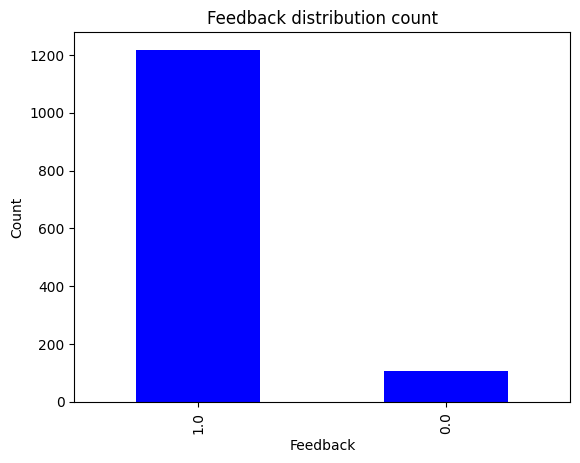

In [ ]:
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [ ]:
print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1.0    91.92
0.0     8.08
Name: count, dtype: float64


<Axes: ylabel='Percentage wise distribution of feedback'>

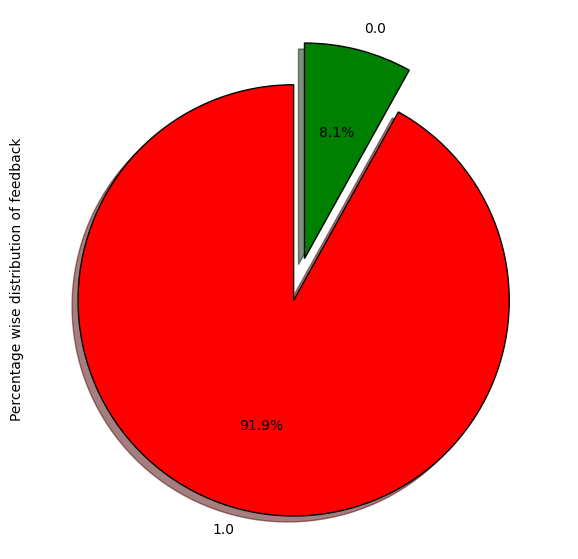

In [ ]:
fig = plt.figure(figsize=(7,7))
colors = ('red','green')
wp = {'linewidth':1, "edgecolor":'black'}
tags = data['feedback'].value_counts()/data.shape[0]
explode=(0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distribution of feedback')

In [ ]:
data[data['feedback']==0]['rating'].value_counts()

rating
5.0    53
1.0    27
4.0    11
2.0     7
4.5     5
3.0     2
0.5     2
Name: count, dtype: int64

In [ ]:
data[data['feedback']==1]['rating'].value_counts()

rating
5.0    792
4.0    216
1.0     66
3.0     62
4.5     36
2.0     20
3.5     18
0.5      5
2.5      2
1.5      1
Name: count, dtype: int64

In [ ]:
data['length'].describe()

count    1325.000000
mean      366.031698
std       273.251293
min        27.000000
25%       272.000000
50%       310.000000
75%       367.000000
max      3252.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review')]

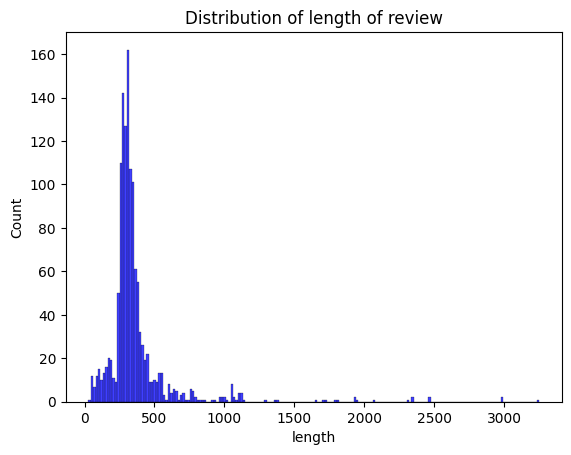

In [ ]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

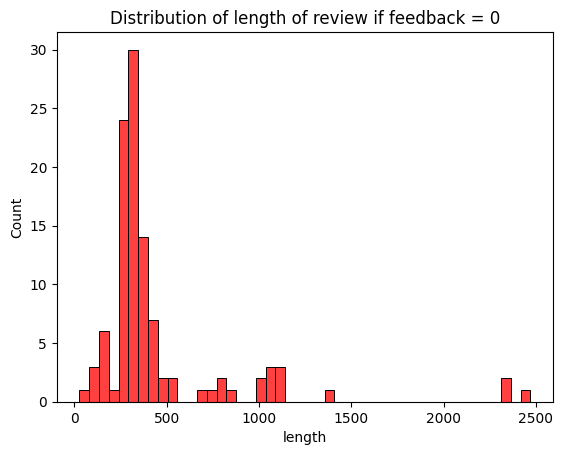

In [ ]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

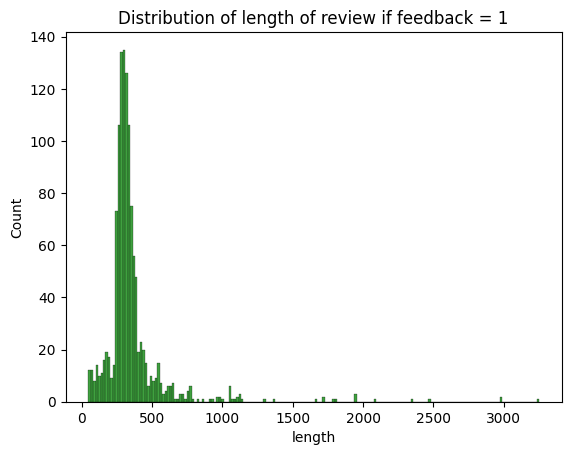

In [ ]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

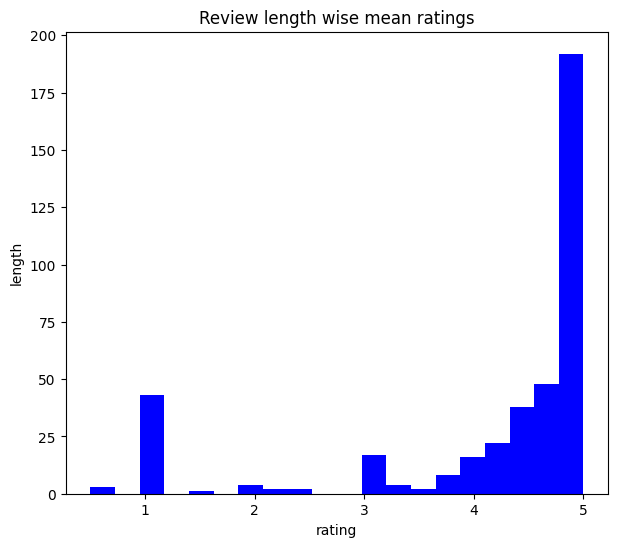

In [ ]:
data.groupby('length')['rating'].mean().plot.hist(color='blue',figsize=(7,6),bins=20)
plt.title("Review length wise mean ratings")
plt.xlabel('rating')
plt.ylabel('length')
plt.show()

In [ ]:
cv=CountVectorizer(stop_words='english')
words=cv.fit_transform(data.verifiedreviews)

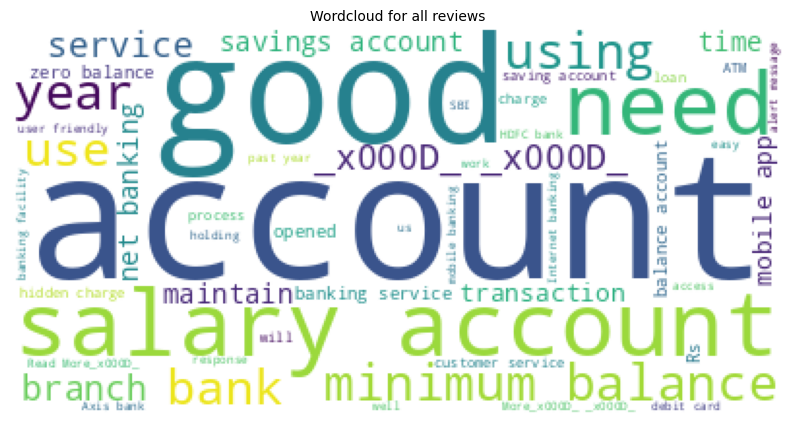

In [ ]:
reviews=" ".join([review for review in data['verifiedreviews']])
wc=WordCloud(background_color='white',max_words=50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews',fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
neg_reviews= " ".join([review for review in data[data['feedback']==0]['verifiedreviews']])
neg_reviews = neg_reviews.lower().split()
pos_reviews = " ".join([review for review in data[data['feedback']==1]['verifiedreviews']])
pos_reviews = pos_reviews.lower().split()
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)
unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

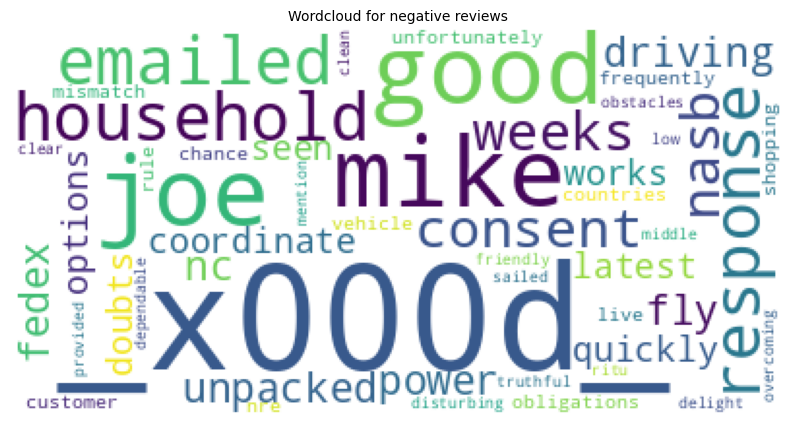

In [ ]:
wc=WordCloud(background_color='white',max_words=50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

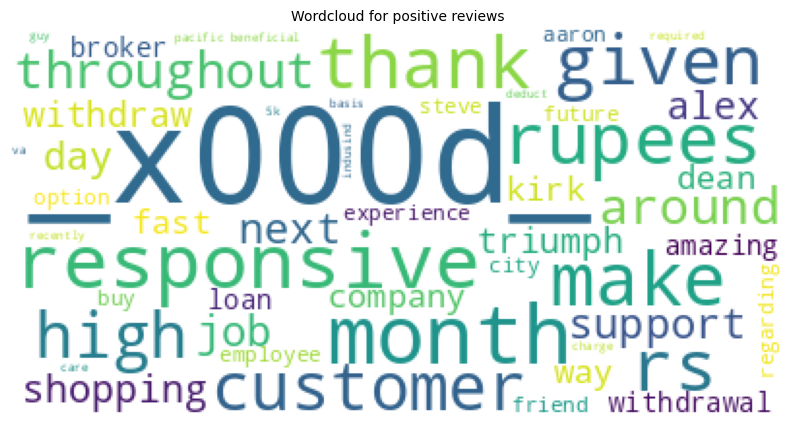

In [ ]:
wc=WordCloud(background_color='white',max_words=50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

**Preprocessing and Modelling**

In [ ]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verifiedreviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [ ]:
cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [ ]:
pickle.dump(cv, open('/content/countVectorizer.pkl', 'wb'))

In [ ]:
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (1325, 2193)
y shape: (1325,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 15)

print(f"x train: {x_train.shape}")
print(f"y train: {y_train.shape}")
print(f"x test: {x_test.shape}")
print(f"y test: {y_test.shape}")

x train: (927, 2193)
y train: (927,)
x test: (398, 2193)
y test: (398,)


In [ ]:
print(f"x train max value: {x_train.max()}")
print(f"x test max value: {x_test.max()}")

x train max value: 19
x test max value: 19


In [ ]:
scaler = MinMaxScaler()
x_train_scl = scaler.fit_transform(x_train)
x_test_scl = scaler.transform(x_test)

In [ ]:
pickle.dump(scaler, open('/content/scaler.pkl', 'wb'))

**Random Forest**

In [ ]:
import numpy as np
nan_indices = np.isnan(y_train)
x_train_cleaned = x_train_scl[~nan_indices]
y_train_cleaned = y_train[~nan_indices]
model_rf=RandomForestClassifier()
model_rf.fit(x_train_cleaned, y_train_cleaned)
nan_indices = np.isnan(y_test)
y_test_cleaned = y_test[~nan_indices]

In [ ]:
print("training accuracy :", model_rf.score(x_train_cleaned,y_train_cleaned))
print("testing accuracy :", model_rf.score(x_test,y_test))

training accuracy : 0.9913700107874865
testing accuracy : 0.9020100502512562


In [ ]:
y_preds = model_rf.predict(x_test)

In [ ]:
cm = confusion_matrix(y_test,y_preds)

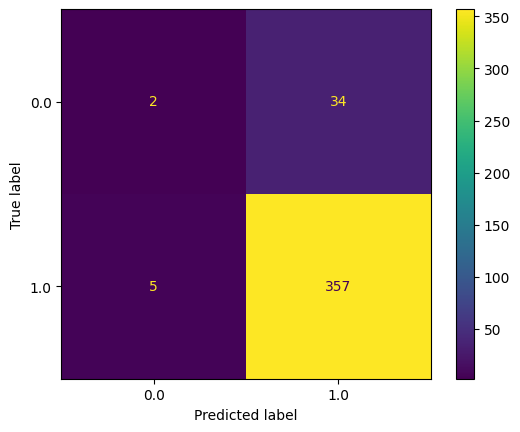

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [ ]:
accuracies = cross_val_score(estimator = model_rf, X = x_train_cleaned, y = y_train, cv = 10)
print("Accuracy:", accuracies.mean())
print("Standard Variance:", accuracies.std())

Accuracy: 0.9158485273492285
Standard Variance: 0.008132492609280792


**XGBoost**

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(x_train_scl,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
print("Training Accuracy :", model_xgb.score(x_train_scl,y_train))
print("Testing Accuracy :", model_xgb.score(x_test_scl,y_test))

Training Accuracy : 0.9881337648327939
Testing Accuracy : 0.8919597989949749


In [ ]:
y_preds = model_xgb.predict(x_test)

In [ ]:
cm = confusion_matrix(y_test,y_preds)
print(cm)

[[  2  34]
 [  8 354]]


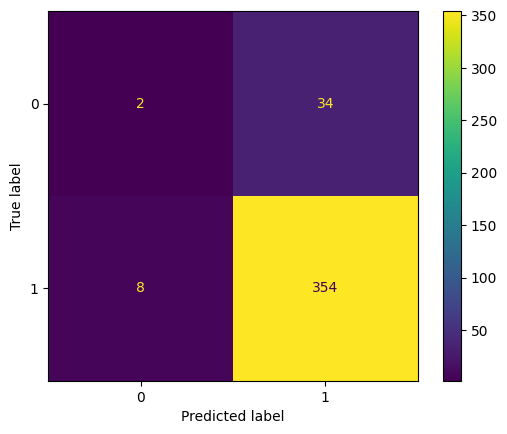

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [ ]:
pickle.dump(model_xgb, open('/content/model_xgb.pkl','wb'))

**Decision Tree**

In [ ]:
model_dt = DecisionTreeClassifier()
model_dt.fit(x_train_scl,y_train)

DecisionTreeClassifier()

In [ ]:
print("Training Accuracy :", model_dt.score(x_train_scl,y_train))
print("Testing Accuracy :", model_dt.score(x_test_scl,y_test))

Training Accuracy : 0.9913700107874865
Testing Accuracy : 0.8668341708542714


In [ ]:
y_preds = model_dt.predict(x_test)

In [ ]:
cm = confusion_matrix(y_test,y_preds)
print(cm)

[[ 13  23]
 [ 90 272]]


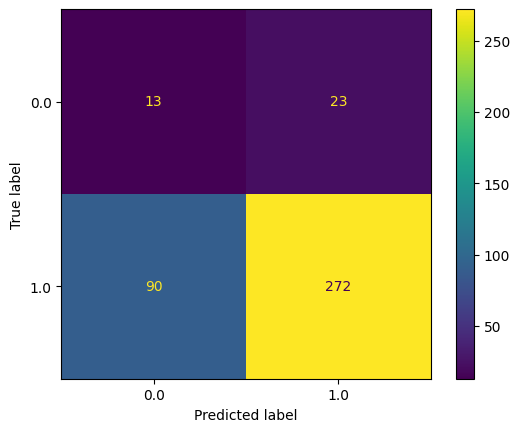

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

**Logistic Regression**

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

nan_indices = np.isnan(y_train)
x_train_cleaned = x_train_scl[~nan_indices]
y_train_cleaned = y_train[~nan_indices]

# Initialize Logistic Regression model
model_lr = LogisticRegression()

# Train the model
model_lr.fit(x_train_cleaned, y_train_cleaned)

nan_indices = np.isnan(y_test)
y_test_cleaned = y_test[~nan_indices]

# Evaluate training and testing accuracies
print("Training accuracy:", model_lr.score(x_train_cleaned, y_train_cleaned))
print("Testing accuracy:", model_lr.score(x_test, y_test_cleaned))


Training accuracy: 0.9503775620280475
Testing accuracy: 0.8844221105527639


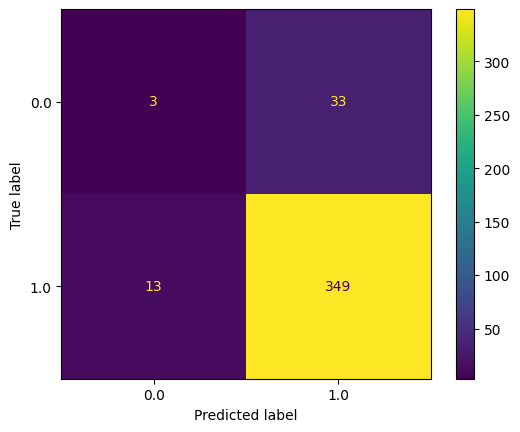

In [ ]:
# Make predictions
y_preds = model_lr.predict(x_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lr.classes_)
cm_display.plot()
plt.show()

In [ ]:
# Perform cross-validation
accuracies = cross_val_score(estimator=model_lr, X=x_train_cleaned, y=y_train_cleaned, cv=10)
print("Accuracy:", accuracies.mean())
print("Standard Variance:", accuracies.std())


Accuracy: 0.9169354838709678
Standard Variance: 0.011876692020578592


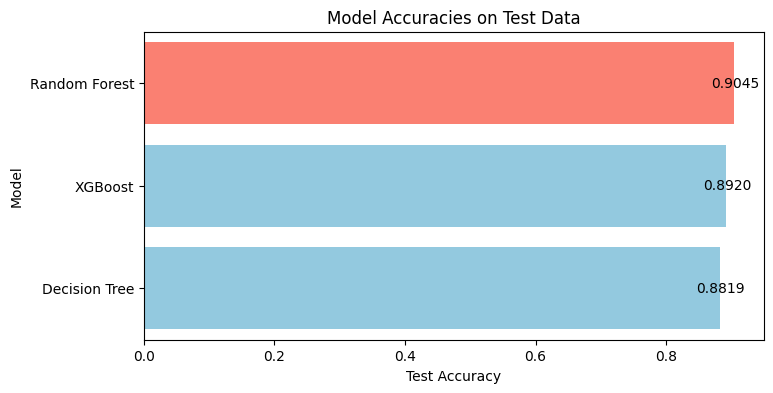

In [ ]:
# Find the index of the best-performing model
best_model_index = model_accuracies['Test Accuracy'].idxmax()

# Plotting the accuracies
plt.figure(figsize=(8, 4))
bars = sns.barplot(data=model_accuracies, y='Model', x='Test Accuracy', color='skyblue')
plt.title('Model Accuracies on Test Data')
plt.xlabel('Test Accuracy')
plt.ylabel('Model')

# Annotate the bars with the accuracy values
for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.4f}', ha='center', va='center', color='black')

# Highlight the bar corresponding to the best-performing model
bars.patches[best_model_index].set_facecolor('salmon')

plt.show()
